# Implementation of Imagenet experiment from Adapting Auxiliary Losses Using Gradient Similarity

## Import neccessary python libraries

In [1]:
import os
import h5py # h5py files library
import pandas as pd # dataframes
import matplotlib.pyplot as plt # plotting and data visualization
import numpy as np # numerical operations
import tensorflow as tf # ML framework of choice
import dask.array as da # Big array handling
from sklearn.model_selection import train_test_split

# Pretty new capability to compute in fly - simillar to pytorch/numpy, with little performance drop
tf.enable_eager_execution() 

Install keras-contrib library with tensorflow bindings, so it will work with eager execution

In [2]:
#!pip uninstall tf_keras_contrib keras_contrib -y
#!pip install git+https://www.github.com/szkocot/keras-contrib.git

Import keras-contrib to see if it works

In [3]:
import keras_contrib

## Specify paths, download data if necessary (colab), load class names and ids mapping
Data is avaliable here: https://drive.google.com/drive/folders/1pVKJvXnxQi3B52yEelCRHsC3hAPwIW7n?usp=sharing

In [4]:
mode = 'local' # local or colab
if mode == 'local':
    data_dir = '/home/szymon/gdrive/imagenet64'
elif mode == 'colab':
    from google.colab import drive
    drive.mount('/content/gdrive', force_remount=True)
    data_dir = '/content/gdrive/My Drive/imagenet64'
    
dataset_file = os.path.join(data_dir,'imagenet64_all.h5')
label_map = pd.read_csv(os.path.join(data_dir,'map_clsloc.txt'), sep=' ', header = None).values[:,1:]

## Create dataframe with class pairs from article
Class ids don't mach, but I adapted numbers to imagenet64 dataset.

In [5]:
pair_df = pd.DataFrame([
    ['ref', 449, '', 449,''],
    ['near', 242, '', 241,''],
    ['near', 3, '', 15,''],
    ['near', 114, '', 79,''],
    ['far', 861, '', 487,''],
    ['far', 771, '', 557,''],
    ['far', 473, '', 861,'']
    ],
    columns = ['type', 'main_id', 'main_name', 'aux_id', 'aux_name'])
fill_names = lambda x: label_map[:,1][label_map[:,0]==x][0].replace("_", " ").lower()
pair_df['main_name'] = pair_df['main_id'].map(fill_names)
pair_df['aux_name'] = pair_df['aux_id'].map(fill_names)
pair_df

,type,main_id,main_name,aux_id,aux_name
0,ref,449,tench,449,tench
1,near,242,trimaran,241,catamaran
2,near,3,siberian husky,15,malamute
3,near,114,greater swiss mountain dog,79,entlebucher
4,far,861,traffic light,487,rock python
5,far,771,hot pot,557,slot
6,far,473,komodo dragon,861,traffic light


## HDF5 file with images and labels

In [6]:
f_data = h5py.File(os.path.join(data_dir,'imagenet64_all.h5'),'r')
labels = np.array(f_data['labels'])
images = da.from_array(f_data['data'], chunks=(1000, 64, 64, 3))

## Samples from each image pairs

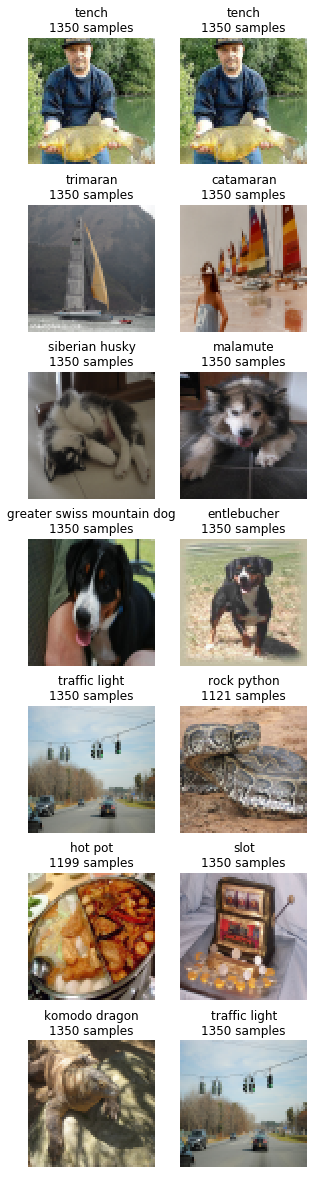

In [7]:
fig = plt.figure(figsize=(5, 21))
axes = []
for i, row in enumerate(pair_df.itertuples()):
    plt.subplot(7,2,2*i+1)
    img = images[labels==row.main_id][-1].compute()
    plt.imshow(img)
    plt.axis('off')
    plt.title('{}\n{} samples'.format(row.main_name,np.sum(labels==row.main_id)))
    plt.subplot(7,2,2*i+2)
    img = images[labels==row.aux_id][-1].compute()
    plt.imshow(img)
    plt.axis('off')
    plt.title('{}\n{} samples'.format(row.aux_name,np.sum(labels==row.aux_id)))

There are 1350 samples from each in whole dataset (training + validation subsets). This is not much, but should be enough.

## Experiment preparation

### Model for future needs

In [8]:
from keras_contrib.applications.resnet import ResNet
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras import Model

Using TensorFlow backend.


Let's create ready to go Resnet-v2-18 model to see how to implement two models with common layers.

In [9]:
model = ResNet(input_shape = (64,64,3), classes = 2, block = 'basic', repetitions=[2, 2, 2, 2])
model.summary()

reshaping via a convolution...
reshaping via a convolution...
reshaping via a convolution...
reshaping via a convolution...
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 64)   9472        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 64)   256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 64)   0           batch_normalization

In [10]:
task_specific_ind = [i for i, x in enumerate(model.variables) if 'dense' in x.name]
shared_ind = [i for i, x in enumerate(model.variables) if 'dense' not in x.name]

print('Task specific variables (dense layer weights):',*[model.variables[x].name for x in task_specific_ind])

Task specific variables (dense layer weights): dense/kernel:0 dense/bias:0


In [11]:
task_specific_ind

[84, 85]

In [12]:
batch_norm_ind = [i for i, x in enumerate(model.variables) if 'batch_norm' in x.name]

### Data preparation and split pipeline

Global mean and std of images - precomputed

In [13]:
m, s = ([122.69337038, 116.67625519, 104.029501], [68.47894011, 66.61391928, 70.2981358])

Function to balance and preload data with specified label, standardize, split into train/test and transform into tf.data.Dataset object

In [14]:
def get_tf_dataset(
    target_label, discard_label, test_fraction = 0.2, verbose = True):
    
    if verbose:
        print('Target label: {}'.format(label_map[:,1][label_map[:,0]==target_label][0]))
    
    target_inds = np.where(labels==target_label)[0]
    other_inds = np.where([True if (x!=target_label) and (x!=discard_label) else False for x in labels])[0]
    other_inds = np.random.choice(other_inds, size = len(target_inds))
    other_inds = other_inds[:len(target_inds)]
    
    all_inds = np.concatenate((target_inds, other_inds), axis = 0)
    all_inds = np.sort(all_inds) # disable to preserve order
    
    if verbose:
        print('Loading data to ram memory ...')
    X = images[all_inds].compute().astype(np.float32)/255
    y = labels[all_inds]
    y = (y==target_label).astype(np.int32)
    
    '''if verbose:
        print('Standardizing data ...')
    for i in range(3):
        X[:,:,:,i] -= m[i]
        X[:,:,:,i] /= s[i]'''
    
    if verbose:
        print('Splitting data to train/test ...')
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_fraction, stratify = y)
    
    if verbose:
        print('Creating tf datasets ...')
    train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    train_ds = train_ds.map(lambda x, y: (tf.to_float(x), tf.one_hot(y, 2)))
    test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))
    test_ds = test_ds.map(lambda x, y: (tf.to_float(x), tf.one_hot(y, 2)))
      
    if verbose:
        print('Finished!')
    
    return train_ds.shuffle(1000), test_ds.shuffle(1000)

### Training and quality measurement helper functions

In [15]:
def loss_fn(y_true, y_pred):
    """Computes loss function using softmax activation function and categorical cross entropy.
    """

    return tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits_v2(
          logits=y_pred, labels=y_true))

def get_avg_acc_loss(dataset, model):
    """Helper function for measuring average loss and accurancy of model.
    """

    def get_accuracy(y_true, y_pred):
        y_pred = tf.argmax(y_pred, 1)
        equality = tf.equal(y_pred, tf.argmax(y_true, 1))
        accuracy = tf.reduce_mean(tf.cast(equality, tf.float32))
        return accuracy
    
    avg_acc = tf.Variable(0,dtype=tf.float32)
    avg_loss = tf.Variable(0,dtype=tf.float32)
    for (batch, (images, labels)) in enumerate(dataset.batch(100)):
        avg_acc = tf.math.add(avg_acc,get_accuracy(labels, model(images)))
        avg_loss = tf.math.add(avg_loss,loss_fn(labels, model(images)))
    
    return avg_acc/(batch+1), avg_loss/(batch+1)

In [16]:
def get_grad_cos_sim(grad1, grad2):
    """Computes cos simillarity of gradients after flattening of tensors.
    
    It hasn't been stated in paper if batch normalization is considered as model trainable parameter,
    but from my perspective only convolutional layer's cosine similarities should be measured.
    """
    
    grad1 = tf.concat(
        [tf.reshape(x,shape=(-1,)) 
         for i, x in enumerate(grad1) 
         if i not in batch_norm_ind+task_specific_ind], 
        axis = 0)
    grad2 = tf.concat(
        [tf.reshape(x,shape=(-1,)) 
         for i, x in enumerate(grad2) 
         if i not in batch_norm_ind+task_specific_ind], 
        axis = 0)
    
    # perform min(max(-1, dist),1) operation for eventual rounding errors (there's about 1 every epoch)
    dist = 1 - tf.losses.cosine_distance(grad1,grad2,axis = 0)
    dist = tf.minimum(tf.maximum(-1, dist),1)
    
    return dist

In [17]:
def try_sum(x1,x2):
    try:
        result = x1+x2
    # when sum(None, None)
    except TypeError:
        result = x1
    return result

#### Training parameters for a,b,c experiments

In [18]:
epochs = 20 # number of epochs
steps = 1000 # numbers of steps per epoch
batch_size = 1
lr = 1e-6 # higher lr causes gradients to be unstable - loss doesn't decrease nicely
cos_sim_dict = {} # dictionary to save cosine similarities

## a) Plot Cosine similarities on near and far pairs
Multi- task training with cosine gradient similarity measurement during training.

In [19]:
# Main loop over pairs
for row in pair_df.itertuples():

    # Clear session
    tf.keras.backend.clear_session()

    run_name = '{} vs {}'.format(row.main_name, row.aux_name)
    cos_sim_dict[run_name] = []

    print('#'*30)
    print(run_name)
    print('#'*30)

    # Create fresh models
    model_main = ResNet(
        input_shape = (64,64,3), classes = 2, 
        block = 'basic', repetitions=[2, 2, 2, 2],
        activation = None)
    model_aux = ResNet(
        input_shape = (64,64,3), classes = 2, 
        block = 'basic', repetitions=[2, 2, 2, 2],
        activation = None)
    
    # Synchronize initial weights
    for (var_main, var_aux) in zip(model_main.variables, model_aux.variables):
        var_aux.assign(var_main.value())

    # optimizer
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=lr)

    # Create main task and aux task datasets
    train_ds_main, test_ds_main = get_tf_dataset(
        row.main_id, row.aux_id, verbose = False)
    train_ds_aux, _ = get_tf_dataset(
        row.aux_id, row.main_id, verbose = False)

    for epoch in range(epochs):

        cos_sim = np.zeros(steps)

        # Iterate over both main and aux task training samples
        for (batch, ((images_main, labels_main), (images_aux, labels_aux))) in enumerate(
            zip(train_ds_main.batch(batch_size), train_ds_aux.batch(batch_size))):

            # Break if we already did enough steps
            if batch == steps:
                break

            # Compute losses
            with tf.GradientTape() as tape_main:
                loss_main = loss_fn(labels_main, model_main(images_main))

            with tf.GradientTape() as tape_aux:
                loss_aux = loss_fn(labels_aux, model_aux(images_aux))

            # compute gradients for shared and private parameters of both tasks
            grads_main = tape_main.gradient(loss_main, model_main.variables)
            grads_aux = tape_aux.gradient(loss_aux, model_aux.variables)

            # measure cosine similarities for gradients of shared layers and append to np.array
            cos_sim[batch] = get_grad_cos_sim(grads_main, grads_aux).numpy()

            # update shared parameters with main and aux task gradients
            ## main model with main gradients
            optimizer.apply_gradients(
                zip(
                    [g for i, g in enumerate(grads_main) 
                     if i not in task_specific_ind],
                    [v for i, v in enumerate(model_main.variables) 
                     if i not in task_specific_ind]))
            ## main model with aux gradients
            optimizer.apply_gradients(
                zip(
                    [g for i, g in enumerate(grads_aux) 
                     if i not in task_specific_ind],
                    [v for i, v in enumerate(model_main.variables) 
                     if i not in task_specific_ind]))
            ## aux model with main gradients
            optimizer.apply_gradients(
                zip(
                    [g for i, g in enumerate(grads_main) 
                     if i not in task_specific_ind],
                    [v for i, v in enumerate(model_aux.variables) 
                     if i not in task_specific_ind]))
            ## aux model with aux gradients
            optimizer.apply_gradients(
                zip(
                    [g for i, g in enumerate(grads_aux) 
                     if i not in task_specific_ind],
                    [v for i, v in enumerate(model_aux.variables) 
                     if i not in task_specific_ind]))
            
            # Apply task specific dense layer parameters
            optimizer.apply_gradients(
                zip(
                    [g_aux for i, g_aux in enumerate(grads_main) 
                     if i in task_specific_ind],
                    [v_aux for i, v_aux in enumerate(model_main.variables) 
                     if i in task_specific_ind]))
            optimizer.apply_gradients(
                zip(
                    [g_aux for i, g_aux in enumerate(grads_aux) 
                     if i in task_specific_ind],
                    [v_aux for i, v_aux in enumerate(model_aux.variables) 
                     if i in task_specific_ind]))

        ## Compute average loss and accurancy for both training and test subset of main task samples
        avg_acc, avg_loss = get_avg_acc_loss(train_ds_main, model_main)
        test_avg_acc, test_avg_loss = get_avg_acc_loss(test_ds_main, model_main)
        
        # Append avg cos sim
        cos_sim_dict[run_name].append(cos_sim.mean())

        ## Print stats
        print("Epoch:{} | loss={:.3f} acc={:.2f}% | val_loss={:.3f} val_acc={:.2f}% | avg_cos_sim={:.3f}".\
        format(epoch+1, avg_loss.numpy(), avg_acc.numpy()*100,test_avg_loss.numpy(), test_avg_acc.numpy()*100, 
               cos_sim.mean()))

##############################
tench vs tench
##############################
reshaping via a convolution...
reshaping via a convolution...
reshaping via a convolution...
reshaping via a convolution...
reshaping via a convolution...
reshaping via a convolution...
reshaping via a convolution...
reshaping via a convolution...
Epoch:1 | loss=1.026 acc=50.02% | val_loss=1.017 val_acc=49.50% | avg_cos_sim=-0.004
Epoch:2 | loss=0.907 acc=55.00% | val_loss=0.910 val_acc=55.58% | avg_cos_sim=0.064
Epoch:3 | loss=0.864 acc=57.30% | val_loss=0.874 val_acc=56.50% | avg_cos_sim=0.004
Epoch:4 | loss=0.810 acc=59.86% | val_loss=0.824 val_acc=59.67% | avg_cos_sim=-0.048
Epoch:5 | loss=0.790 acc=59.79% | val_loss=0.771 val_acc=62.58% | avg_cos_sim=-0.020
Epoch:6 | loss=0.755 acc=61.18% | val_loss=0.747 val_acc=63.92% | avg_cos_sim=0.020
Epoch:7 | loss=0.736 acc=61.65% | val_loss=0.734 val_acc=64.25% | avg_cos_sim=-0.014
Epoch:8 | loss=0.716 acc=62.42% | val_loss=0.713 val_acc=64.33% | avg_cos_sim=-0.01

reshaping via a convolution...
reshaping via a convolution...
reshaping via a convolution...
Epoch:1 | loss=1.141 acc=46.33% | val_loss=1.191 val_acc=45.00% | avg_cos_sim=0.113
Epoch:2 | loss=1.043 acc=49.79% | val_loss=1.077 val_acc=48.58% | avg_cos_sim=-0.002
Epoch:3 | loss=0.986 acc=51.00% | val_loss=1.060 val_acc=48.33% | avg_cos_sim=0.032
Epoch:4 | loss=0.950 acc=52.06% | val_loss=1.025 val_acc=47.75% | avg_cos_sim=-0.094
Epoch:5 | loss=0.929 acc=53.15% | val_loss=0.976 val_acc=51.58% | avg_cos_sim=-0.014
Epoch:6 | loss=0.900 acc=55.38% | val_loss=0.944 val_acc=51.17% | avg_cos_sim=-0.028
Epoch:7 | loss=0.883 acc=55.50% | val_loss=0.973 val_acc=49.75% | avg_cos_sim=-0.018
Epoch:8 | loss=0.857 acc=56.11% | val_loss=0.939 val_acc=49.92% | avg_cos_sim=0.012
Epoch:9 | loss=0.836 acc=57.05% | val_loss=0.912 val_acc=51.33% | avg_cos_sim=0.052
Epoch:10 | loss=0.823 acc=57.80% | val_loss=0.880 val_acc=52.58% | avg_cos_sim=0.042
Epoch:11 | loss=0.818 acc=57.91% | val_loss=0.924 val_acc=51.

In [20]:
df = pd.DataFrame.from_dict(cos_sim_dict)
#df.to_csv('../bckp/imagenet_1.csv')

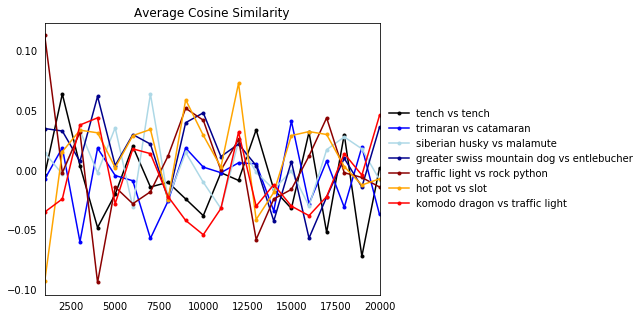

In [35]:
df = pd.read_csv('../bckp/imagenet_1.csv', index_col = 0)
df.index = [(x+1)*steps for x in df.index]
styles = ['black','blue','lightblue', 'darkblue', 'darkred', 'orange','red']
fig, ax = plt.subplots(figsize=(6,5))
for col, style in zip(df.columns, styles):
    df[col].plot(style=style, ax=ax, marker = '.')
ax.legend(frameon=False, loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Average Cosine Similarity')
ax.xaxis.set_ticks_position('none') # remove xticks - as in paper
ax.yaxis.set_ticks_position('none') # remove yticks - as in paper

## b) Comparsion of training methods on near pairs: trimaran vs catamaran

In [24]:
avg_acc_dict = {} # dictionary for avg test acc

In [25]:
train_ds_main, test_ds_main = get_tf_dataset(
    242, 241, verbose = False)
train_ds_aux, test_ds_aux = get_tf_dataset(
    241, 242, verbose = False)

### Single Task training

In [26]:
avg_acc_dict['Single Task'] = []

# Create fresh models
model_main = ResNet(
        input_shape = (64,64,3), classes = 2, 
        block = 'basic', repetitions=[2, 2, 2, 2],
        activation = None)

# optimizer
optimizer = tf.train.GradientDescentOptimizer(learning_rate=lr)

for epoch in range(epochs):

    # Iterate over main training samples
    for batch, (images_main, labels_main) in enumerate(train_ds_main.batch(batch_size)):

        # Break if we already did enough steps
        if batch == steps:
            break

        # Compute loss
        with tf.GradientTape() as tape_main:
            loss_main = loss_fn(labels_main, model_main(images_main))

        # compute gradients for shared and private parameters of both tasks
        grads_main = tape_main.gradient(loss_main, model_main.variables)

        # update all main task model parameters
        optimizer.apply_gradients(
            zip(
                grads_main, 
                model_main.variables))

    ## Compute average loss and accurancy for train andtest subset of main task samples
    avg_acc, avg_loss = get_avg_acc_loss(train_ds_main, model_main)
    test_avg_acc, test_avg_loss = get_avg_acc_loss(test_ds_main, model_main)

    # Append avg cos sim
    avg_acc_dict['Single Task'].append(test_avg_acc.numpy())

    ## Print stats
    print("Epoch:{} | loss={:.3f} acc={:.2f}% | val_loss={:.3f} val_acc={:.2f}%".\
    format(epoch+1, avg_loss.numpy(), avg_acc.numpy()*100,test_avg_loss.numpy(), test_avg_acc.numpy()*100))

reshaping via a convolution...
reshaping via a convolution...
reshaping via a convolution...
reshaping via a convolution...
Epoch:1 | loss=0.899 acc=60.35% | val_loss=0.949 val_acc=59.25%
Epoch:2 | loss=0.764 acc=67.62% | val_loss=0.805 val_acc=67.25%
Epoch:3 | loss=0.682 acc=70.77% | val_loss=0.721 val_acc=70.33%
Epoch:4 | loss=0.638 acc=72.58% | val_loss=0.714 val_acc=72.67%
Epoch:5 | loss=0.612 acc=74.11% | val_loss=0.689 val_acc=73.08%
Epoch:6 | loss=0.592 acc=75.06% | val_loss=0.668 val_acc=72.83%
Epoch:7 | loss=0.571 acc=75.61% | val_loss=0.639 val_acc=74.08%
Epoch:8 | loss=0.577 acc=76.08% | val_loss=0.645 val_acc=74.25%
Epoch:9 | loss=0.542 acc=77.02% | val_loss=0.598 val_acc=76.67%
Epoch:10 | loss=0.534 acc=77.82% | val_loss=0.594 val_acc=75.92%
Epoch:11 | loss=0.522 acc=77.56% | val_loss=0.575 val_acc=77.17%
Epoch:12 | loss=0.515 acc=78.42% | val_loss=0.594 val_acc=76.25%
Epoch:13 | loss=0.499 acc=79.17% | val_loss=0.566 val_acc=76.83%
Epoch:14 | loss=0.527 acc=77.08% | val_l

### Proposed Method

In [27]:
avg_acc_dict['Proposed Method'] = []

# Create fresh models
model_main = ResNet(
        input_shape = (64,64,3), classes = 2, 
        block = 'basic', repetitions=[2, 2, 2, 2],
        activation = None)
model_aux = ResNet(
        input_shape = (64,64,3), classes = 2, 
        block = 'basic', repetitions=[2, 2, 2, 2],
        activation = None)

# Synchronize initial weights
for (var_main, var_aux) in zip(model_main.variables, model_aux.variables):
    var_aux.assign(var_main.value())

# optimizer
optimizer = tf.train.GradientDescentOptimizer(learning_rate=lr)

for epoch in range(epochs):

    # Iterate over both main and aux task training samples
    for (batch, ((images_main, labels_main), (images_aux, labels_aux))) in enumerate(
        zip(train_ds_main.batch(batch_size), train_ds_aux.batch(batch_size))):

        # Break if we already did enough steps
        if batch == steps:
            break

        # Compute losses
        with tf.GradientTape() as tape_main:
            loss_main = loss_fn(labels_main, model_main(images_main))

        with tf.GradientTape() as tape_aux:
            loss_aux = loss_fn(labels_aux, model_aux(images_aux))

        # compute gradients for shared and private parameters of both tasks
        grads_main = tape_main.gradient(loss_main, model_main.variables)
        grads_aux = tape_aux.gradient(loss_aux, model_aux.variables)

        # compute cosine similarity for shared gradients of both tasks and decide how to update shared parameters
        # Upgrading only main model will case aux model to update at the same time - they share layers and weights
        if get_grad_cos_sim(grads_main, grads_aux)>=0:
            
            grad_sum = [try_sum(x1,x2) for (x1, x2) in zip(
                grads_main,grads_aux)]
            
            ## main model with combined gradients
            optimizer.apply_gradients(
                zip(
                    [g for i, g in enumerate(grad_sum) 
                     if i not in task_specific_ind],
                    [v for i, v in enumerate(model_main.variables) 
                     if i not in task_specific_ind]))
            
            ## aux model with combined gradients
            optimizer.apply_gradients(
                zip(
                    [g for i, g in enumerate(grad_sum) 
                     if i not in task_specific_ind],
                    [v for i, v in enumerate(model_aux.variables) 
                     if i not in task_specific_ind]))
        else:
            
            ## aux model with main gradients
            optimizer.apply_gradients(
                zip(
                    [g for i, g in enumerate(grads_main) 
                     if i not in task_specific_ind],
                    [v for i, v in enumerate(model_main.variables) 
                     if i not in task_specific_ind]))
            
            ## aux model with aux gradients
            optimizer.apply_gradients(
                zip(
                    [g for i, g in enumerate(grads_aux) 
                     if i not in task_specific_ind],
                    [v for i, v in enumerate(model_aux.variables) 
                     if i not in task_specific_ind]))
        
        # Apply task specific dense layer parameters
        optimizer.apply_gradients(
            zip(
                [g_aux for i, g_aux in enumerate(grads_main) 
                 if i in task_specific_ind],
                [v_aux for i, v_aux in enumerate(model_main.variables) 
                 if i in task_specific_ind]))
        optimizer.apply_gradients(
            zip(
                [g_aux for i, g_aux in enumerate(grads_aux) 
                 if i in task_specific_ind],
                [v_aux for i, v_aux in enumerate(model_aux.variables) 
                 if i in task_specific_ind]))

    ## Compute average loss and accurancy for train andtest subset of main task samples
    avg_acc, avg_loss = get_avg_acc_loss(train_ds_main, model_main)
    test_avg_acc, test_avg_loss = get_avg_acc_loss(test_ds_main, model_main)

    # Append avg cos sim
    avg_acc_dict['Proposed Method'].append(test_avg_acc.numpy())

    ## Print stats
    print("Epoch:{} | loss={:.3f} acc={:.2f}% | val_loss={:.3f} val_acc={:.2f}%".\
    format(epoch+1, avg_loss.numpy(), avg_acc.numpy()*100,test_avg_loss.numpy(), test_avg_acc.numpy()*100))

reshaping via a convolution...
reshaping via a convolution...
reshaping via a convolution...
reshaping via a convolution...
reshaping via a convolution...
reshaping via a convolution...
reshaping via a convolution...
reshaping via a convolution...
Epoch:1 | loss=0.956 acc=63.79% | val_loss=0.947 val_acc=64.33%
Epoch:2 | loss=0.727 acc=70.09% | val_loss=0.685 val_acc=70.08%
Epoch:3 | loss=0.661 acc=73.47% | val_loss=0.680 val_acc=73.42%
Epoch:4 | loss=0.688 acc=73.29% | val_loss=0.679 val_acc=74.17%
Epoch:5 | loss=0.561 acc=77.68% | val_loss=0.524 val_acc=78.75%
Epoch:6 | loss=0.563 acc=78.32% | val_loss=0.523 val_acc=80.92%
Epoch:7 | loss=0.543 acc=78.94% | val_loss=0.516 val_acc=80.25%
Epoch:8 | loss=0.516 acc=79.77% | val_loss=0.509 val_acc=80.08%
Epoch:9 | loss=0.521 acc=79.05% | val_loss=0.522 val_acc=80.00%
Epoch:10 | loss=0.518 acc=79.52% | val_loss=0.546 val_acc=77.58%
Epoch:11 | loss=0.489 acc=80.64% | val_loss=0.512 val_acc=79.67%
Epoch:12 | loss=0.477 acc=81.33% | val_loss=0.

### Multi-task training

In [28]:
avg_acc_dict['Multi-Task'] = []

# Create fresh models
model_main = ResNet(
        input_shape = (64,64,3), classes = 2, 
        block = 'basic', repetitions=[2, 2, 2, 2],
        activation = None)
model_aux = ResNet(
        input_shape = (64,64,3), classes = 2, 
        block = 'basic', repetitions=[2, 2, 2, 2],
        activation = None)

# Synchronize initial weights
for (var_main, var_aux) in zip(model_main.variables, model_aux.variables):
    var_aux.assign(var_main.value())

# optimizer
optimizer = tf.train.GradientDescentOptimizer(learning_rate=lr)

for epoch in range(epochs):

    # Iterate over both main and aux task training samples
    for (batch, ((images_main, labels_main), (images_aux, labels_aux))) in enumerate(
        zip(train_ds_main.batch(batch_size), train_ds_aux.batch(batch_size))):

        # Break if we already did enough steps
        if batch == steps:
            break

        # Compute losses
        with tf.GradientTape() as tape_main:
            loss_main = loss_fn(labels_main, model_main(images_main))

        with tf.GradientTape() as tape_aux:
            loss_aux = loss_fn(labels_aux, model_aux(images_aux))

        # compute gradients for shared and private parameters of both tasks
        grads_main = tape_main.gradient(loss_main, model_main.variables)
        grads_aux = tape_aux.gradient(loss_aux, model_aux.variables)

        # update shared parameters with main and aux task gradients
        ## main model with main gradients
        optimizer.apply_gradients(
            zip(
                [g for i, g in enumerate(grads_main) 
                 if i not in task_specific_ind],
                [v for i, v in enumerate(model_main.variables) 
                 if i not in task_specific_ind]))
        ## main model with aux gradients
        optimizer.apply_gradients(
            zip(
                [g for i, g in enumerate(grads_aux) 
                 if i not in task_specific_ind],
                [v for i, v in enumerate(model_main.variables) 
                 if i not in task_specific_ind]))
        ## aux model with main gradients
        optimizer.apply_gradients(
            zip(
                [g for i, g in enumerate(grads_main) 
                 if i not in task_specific_ind],
                [v for i, v in enumerate(model_aux.variables) 
                 if i not in task_specific_ind]))
        ## aux model with aux gradients
        optimizer.apply_gradients(
            zip(
                [g for i, g in enumerate(grads_aux) 
                 if i not in task_specific_ind],
                [v for i, v in enumerate(model_aux.variables) 
                 if i not in task_specific_ind]))

        # Apply task specific dense layer parameters
        optimizer.apply_gradients(
            zip(
                [g_aux for i, g_aux in enumerate(grads_main) 
                 if i in task_specific_ind],
                [v_aux for i, v_aux in enumerate(model_main.variables) 
                 if i in task_specific_ind]))
        optimizer.apply_gradients(
            zip(
                [g_aux for i, g_aux in enumerate(grads_aux) 
                 if i in task_specific_ind],
                [v_aux for i, v_aux in enumerate(model_aux.variables) 
                 if i in task_specific_ind]))

    ## Compute average loss and accurancy for train andtest subset of main task samples
    avg_acc, avg_loss = get_avg_acc_loss(train_ds_main, model_main)
    test_avg_acc, test_avg_loss = get_avg_acc_loss(test_ds_main, model_main)

    # Append avg cos sim
    avg_acc_dict['Multi-Task'].append(test_avg_acc.numpy())

    ## Print stats
    print("Epoch:{} | loss={:.3f} acc={:.2f}% | val_loss={:.3f} val_acc={:.2f}%".\
    format(epoch+1, avg_loss.numpy(), avg_acc.numpy()*100,test_avg_loss.numpy(), test_avg_acc.numpy()*100))

reshaping via a convolution...
reshaping via a convolution...
reshaping via a convolution...
reshaping via a convolution...
reshaping via a convolution...
reshaping via a convolution...
reshaping via a convolution...
reshaping via a convolution...
Epoch:1 | loss=0.886 acc=59.41% | val_loss=0.875 val_acc=58.00%
Epoch:2 | loss=0.648 acc=71.53% | val_loss=0.610 val_acc=72.25%
Epoch:3 | loss=0.582 acc=75.35% | val_loss=0.536 val_acc=76.42%
Epoch:4 | loss=0.546 acc=77.53% | val_loss=0.501 val_acc=79.17%
Epoch:5 | loss=0.517 acc=78.58% | val_loss=0.494 val_acc=79.75%
Epoch:6 | loss=0.501 acc=79.41% | val_loss=0.492 val_acc=80.42%
Epoch:7 | loss=0.494 acc=79.08% | val_loss=0.480 val_acc=80.67%
Epoch:8 | loss=0.478 acc=80.05% | val_loss=0.439 val_acc=83.08%
Epoch:9 | loss=0.470 acc=80.15% | val_loss=0.460 val_acc=81.50%
Epoch:10 | loss=0.463 acc=80.64% | val_loss=0.455 val_acc=80.67%
Epoch:11 | loss=0.453 acc=80.91% | val_loss=0.429 val_acc=82.00%
Epoch:12 | loss=0.447 acc=81.30% | val_loss=0.

In [29]:
df = pd.DataFrame.from_dict(avg_acc_dict)
#df.to_csv('../bckp/imagenet_2.csv')

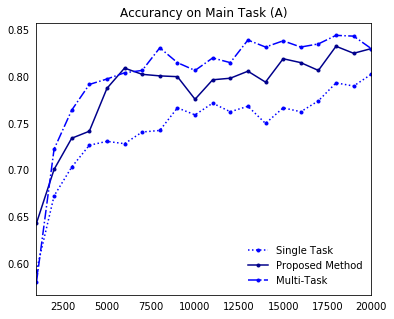

In [36]:
df = pd.read_csv('../bckp/imagenet_2.csv', index_col = 0)
df.index = [(x+1)*steps for x in df.index]
styles = ['blue','darkblue','blue']
linestyle = [':','-','-.']
fig, ax = plt.subplots(figsize=(6,5))
for col, style, ls in zip(df.columns, styles, linestyle):
    df[col].plot(style=style, ax=ax, linestyle=ls, marker = '.')
ax.legend(frameon=False)
plt.title('Accurancy on Main Task (A)')
ax.xaxis.set_ticks_position('none') # remove xticks - as in paper
ax.yaxis.set_ticks_position('none') # remove yticks - as in paper

## c) Comparsion of training methods on near pairs: komodo dragon  vs traffic light

In [19]:
avg_acc_dict = {} # dictionary for avg test acc

In [20]:
train_ds_main, test_ds_main = get_tf_dataset(
    473, 861, verbose = False)
train_ds_aux, test_ds_aux = get_tf_dataset(
    861, 473, verbose = False)

### Single Task training

In [21]:
avg_acc_dict['Single Task'] = []

# Create fresh models
model_main = ResNet(
        input_shape = (64,64,3), classes = 2, 
        block = 'basic', repetitions=[2, 2, 2, 2],
        activation = None)

# optimizer
optimizer = tf.train.GradientDescentOptimizer(learning_rate=lr)

for epoch in range(epochs):

    # Iterate over main training samples
    for batch, (images_main, labels_main) in enumerate(train_ds_main.batch(batch_size)):

        # Break if we already did enough steps
        if batch == steps:
            break

        # Compute loss
        with tf.GradientTape() as tape_main:
            loss_main = loss_fn(labels_main, model_main(images_main))

        # compute gradients for shared and private parameters of both tasks
        grads_main = tape_main.gradient(loss_main, model_main.variables)

        # update all main task model parameters
        optimizer.apply_gradients(
            zip(
                grads_main, 
                model_main.variables))

    ## Compute average loss and accurancy for train andtest subset of main task samples
    avg_acc, avg_loss = get_avg_acc_loss(train_ds_main, model_main)
    test_avg_acc, test_avg_loss = get_avg_acc_loss(test_ds_main, model_main)

    # Append avg cos sim
    avg_acc_dict['Single Task'].append(test_avg_acc.numpy())

    ## Print stats
    print("Epoch:{} | loss={:.3f} acc={:.2f}% | val_loss={:.3f} val_acc={:.2f}%".\
    format(epoch+1, avg_loss.numpy(), avg_acc.numpy()*100,test_avg_loss.numpy(), test_avg_acc.numpy()*100))

reshaping via a convolution...
reshaping via a convolution...
reshaping via a convolution...
reshaping via a convolution...
Epoch:1 | loss=0.924 acc=50.64% | val_loss=0.921 val_acc=52.50%
Epoch:2 | loss=0.855 acc=53.33% | val_loss=0.884 val_acc=51.75%
Epoch:3 | loss=0.825 acc=55.52% | val_loss=0.857 val_acc=52.67%
Epoch:4 | loss=0.805 acc=56.77% | val_loss=0.852 val_acc=55.17%
Epoch:5 | loss=0.784 acc=57.89% | val_loss=0.840 val_acc=53.83%
Epoch:6 | loss=0.767 acc=59.14% | val_loss=0.833 val_acc=53.92%
Epoch:7 | loss=0.756 acc=59.14% | val_loss=0.814 val_acc=56.00%
Epoch:8 | loss=0.739 acc=60.24% | val_loss=0.823 val_acc=54.50%
Epoch:9 | loss=0.743 acc=60.11% | val_loss=0.820 val_acc=55.08%
Epoch:10 | loss=0.726 acc=61.29% | val_loss=0.816 val_acc=56.08%
Epoch:11 | loss=0.706 acc=61.97% | val_loss=0.797 val_acc=56.17%
Epoch:12 | loss=0.699 acc=62.06% | val_loss=0.779 val_acc=57.58%
Epoch:13 | loss=0.703 acc=62.53% | val_loss=0.769 val_acc=56.75%
Epoch:14 | loss=0.693 acc=62.64% | val_l

### Proposed Method

In [22]:
avg_acc_dict['Proposed Method'] = []

# Create fresh models
model_main = ResNet(
        input_shape = (64,64,3), classes = 2, 
        block = 'basic', repetitions=[2, 2, 2, 2],
        activation = None)
model_aux = ResNet(
        input_shape = (64,64,3), classes = 2, 
        block = 'basic', repetitions=[2, 2, 2, 2],
        activation = None)

# Synchronize initial weights
for (var_main, var_aux) in zip(model_main.variables, model_aux.variables):
    var_aux.assign(var_main.value())

# optimizer
optimizer = tf.train.GradientDescentOptimizer(learning_rate=lr)

for epoch in range(epochs):

    # Iterate over both main and aux task training samples
    for (batch, ((images_main, labels_main), (images_aux, labels_aux))) in enumerate(
        zip(train_ds_main.batch(batch_size), train_ds_aux.batch(batch_size))):

        # Break if we already did enough steps
        if batch == steps:
            break

        # Compute losses
        with tf.GradientTape() as tape_main:
            loss_main = loss_fn(labels_main, model_main(images_main))

        with tf.GradientTape() as tape_aux:
            loss_aux = loss_fn(labels_aux, model_aux(images_aux))

        # compute gradients for shared and private parameters of both tasks
        grads_main = tape_main.gradient(loss_main, model_main.variables)
        grads_aux = tape_aux.gradient(loss_aux, model_aux.variables)

        # compute cosine similarity for shared gradients of both tasks and decide how to update shared parameters
        # Upgrading only main model will case aux model to update at the same time - they share layers and weights
        if get_grad_cos_sim(grads_main, grads_aux)>=0:
            
            grad_sum = [try_sum(x1,x2) for (x1, x2) in zip(
                grads_main,grads_aux)]
            
            ## main model with combined gradients
            optimizer.apply_gradients(
                zip(
                    [g for i, g in enumerate(grad_sum) 
                     if i not in task_specific_ind],
                    [v for i, v in enumerate(model_main.variables) 
                     if i not in task_specific_ind]))
            
            ## aux model with combined gradients
            optimizer.apply_gradients(
                zip(
                    [g for i, g in enumerate(grad_sum) 
                     if i not in task_specific_ind],
                    [v for i, v in enumerate(model_aux.variables) 
                     if i not in task_specific_ind]))
        else:
            
            ## aux model with main gradients
            optimizer.apply_gradients(
                zip(
                    [g for i, g in enumerate(grads_main) 
                     if i not in task_specific_ind],
                    [v for i, v in enumerate(model_main.variables) 
                     if i not in task_specific_ind]))
            
            ## aux model with aux gradients
            optimizer.apply_gradients(
                zip(
                    [g for i, g in enumerate(grads_aux) 
                     if i not in task_specific_ind],
                    [v for i, v in enumerate(model_aux.variables) 
                     if i not in task_specific_ind]))
        
        # Apply task specific dense layer parameters
        optimizer.apply_gradients(
            zip(
                [g_aux for i, g_aux in enumerate(grads_main) 
                 if i in task_specific_ind],
                [v_aux for i, v_aux in enumerate(model_main.variables) 
                 if i in task_specific_ind]))
        optimizer.apply_gradients(
            zip(
                [g_aux for i, g_aux in enumerate(grads_aux) 
                 if i in task_specific_ind],
                [v_aux for i, v_aux in enumerate(model_aux.variables) 
                 if i in task_specific_ind]))

    ## Compute average loss and accurancy for train andtest subset of main task samples
    avg_acc, avg_loss = get_avg_acc_loss(train_ds_main, model_main)
    test_avg_acc, test_avg_loss = get_avg_acc_loss(test_ds_main, model_main)

    # Append avg cos sim
    avg_acc_dict['Proposed Method'].append(test_avg_acc.numpy())

    ## Print stats
    print("Epoch:{} | loss={:.3f} acc={:.2f}% | val_loss={:.3f} val_acc={:.2f}%".\
    format(epoch+1, avg_loss.numpy(), avg_acc.numpy()*100,test_avg_loss.numpy(), test_avg_acc.numpy()*100))

reshaping via a convolution...
reshaping via a convolution...
reshaping via a convolution...
reshaping via a convolution...
reshaping via a convolution...
reshaping via a convolution...
reshaping via a convolution...
reshaping via a convolution...
Epoch:1 | loss=1.178 acc=54.67% | val_loss=1.320 val_acc=48.08%
Epoch:2 | loss=1.098 acc=56.67% | val_loss=1.219 val_acc=52.75%
Epoch:3 | loss=1.098 acc=56.53% | val_loss=1.244 val_acc=53.08%
Epoch:4 | loss=0.911 acc=58.44% | val_loss=1.040 val_acc=55.58%
Epoch:5 | loss=0.880 acc=59.38% | val_loss=0.981 val_acc=57.75%
Epoch:6 | loss=0.859 acc=59.15% | val_loss=0.954 val_acc=58.08%
Epoch:7 | loss=0.884 acc=57.79% | val_loss=0.988 val_acc=53.83%
Epoch:8 | loss=0.809 acc=60.82% | val_loss=0.930 val_acc=55.08%
Epoch:9 | loss=0.803 acc=62.14% | val_loss=0.897 val_acc=57.50%
Epoch:10 | loss=0.772 acc=63.00% | val_loss=0.893 val_acc=56.08%
Epoch:11 | loss=0.753 acc=64.09% | val_loss=0.857 val_acc=57.50%
Epoch:12 | loss=0.754 acc=64.27% | val_loss=0.

### Multi-task training

In [23]:
avg_acc_dict['Multi-Task'] = []

# Create fresh models
model_main = ResNet(
        input_shape = (64,64,3), classes = 2, 
        block = 'basic', repetitions=[2, 2, 2, 2],
        activation = None)
model_aux = ResNet(
        input_shape = (64,64,3), classes = 2, 
        block = 'basic', repetitions=[2, 2, 2, 2],
        activation = None)

# Synchronize initial weights
for (var_main, var_aux) in zip(model_main.variables, model_aux.variables):
    var_aux.assign(var_main.value())

# optimizer
optimizer = tf.train.GradientDescentOptimizer(learning_rate=lr)

for epoch in range(epochs):

    # Iterate over both main and aux task training samples
    for (batch, ((images_main, labels_main), (images_aux, labels_aux))) in enumerate(
        zip(train_ds_main.batch(batch_size), train_ds_aux.batch(batch_size))):

        # Break if we already did enough steps
        if batch == steps:
            break

        # Compute losses
        with tf.GradientTape() as tape_main:
            loss_main = loss_fn(labels_main, model_main(images_main))

        with tf.GradientTape() as tape_aux:
            loss_aux = loss_fn(labels_aux, model_aux(images_aux))

        # compute gradients for shared and private parameters of both tasks
        grads_main = tape_main.gradient(loss_main, model_main.variables)
        grads_aux = tape_aux.gradient(loss_aux, model_aux.variables)

        # update shared parameters with main and aux task gradients
        ## main model with main gradients
        optimizer.apply_gradients(
            zip(
                [g for i, g in enumerate(grads_main) 
                 if i not in task_specific_ind],
                [v for i, v in enumerate(model_main.variables) 
                 if i not in task_specific_ind]))
        ## main model with aux gradients
        optimizer.apply_gradients(
            zip(
                [g for i, g in enumerate(grads_aux) 
                 if i not in task_specific_ind],
                [v for i, v in enumerate(model_main.variables) 
                 if i not in task_specific_ind]))
        ## aux model with main gradients
        optimizer.apply_gradients(
            zip(
                [g for i, g in enumerate(grads_main) 
                 if i not in task_specific_ind],
                [v for i, v in enumerate(model_aux.variables) 
                 if i not in task_specific_ind]))
        ## aux model with aux gradients
        optimizer.apply_gradients(
            zip(
                [g for i, g in enumerate(grads_aux) 
                 if i not in task_specific_ind],
                [v for i, v in enumerate(model_aux.variables) 
                 if i not in task_specific_ind]))

        # Apply task specific dense layer parameters
        optimizer.apply_gradients(
            zip(
                [g_aux for i, g_aux in enumerate(grads_main) 
                 if i in task_specific_ind],
                [v_aux for i, v_aux in enumerate(model_main.variables) 
                 if i in task_specific_ind]))
        optimizer.apply_gradients(
            zip(
                [g_aux for i, g_aux in enumerate(grads_aux) 
                 if i in task_specific_ind],
                [v_aux for i, v_aux in enumerate(model_aux.variables) 
                 if i in task_specific_ind]))

    ## Compute average loss and accurancy for train andtest subset of main task samples
    avg_acc, avg_loss = get_avg_acc_loss(train_ds_main, model_main)
    test_avg_acc, test_avg_loss = get_avg_acc_loss(test_ds_main, model_main)

    # Append avg cos sim
    avg_acc_dict['Multi-Task'].append(test_avg_acc.numpy())

    ## Print stats
    print("Epoch:{} | loss={:.3f} acc={:.2f}% | val_loss={:.3f} val_acc={:.2f}%".\
    format(epoch+1, avg_loss.numpy(), avg_acc.numpy()*100,test_avg_loss.numpy(), test_avg_acc.numpy()*100))

reshaping via a convolution...
reshaping via a convolution...
reshaping via a convolution...
reshaping via a convolution...
reshaping via a convolution...
reshaping via a convolution...
reshaping via a convolution...
reshaping via a convolution...
Epoch:1 | loss=0.996 acc=54.47% | val_loss=1.082 val_acc=53.00%
Epoch:2 | loss=0.958 acc=53.35% | val_loss=1.055 val_acc=51.42%
Epoch:3 | loss=0.914 acc=52.91% | val_loss=0.997 val_acc=52.67%
Epoch:4 | loss=0.915 acc=53.67% | val_loss=0.978 val_acc=54.00%
Epoch:5 | loss=0.865 acc=53.80% | val_loss=0.986 val_acc=51.58%
Epoch:6 | loss=0.834 acc=54.77% | val_loss=0.914 val_acc=51.50%
Epoch:7 | loss=0.828 acc=55.21% | val_loss=0.882 val_acc=52.58%
Epoch:8 | loss=0.812 acc=55.85% | val_loss=0.903 val_acc=52.92%
Epoch:9 | loss=0.808 acc=55.47% | val_loss=0.862 val_acc=54.58%
Epoch:10 | loss=0.786 acc=56.44% | val_loss=0.866 val_acc=54.83%
Epoch:11 | loss=0.784 acc=57.33% | val_loss=0.866 val_acc=52.58%
Epoch:12 | loss=0.764 acc=57.41% | val_loss=0.

In [24]:
df = pd.DataFrame.from_dict(avg_acc_dict)
#df.to_csv('../bckp/imagenet_3.csv')

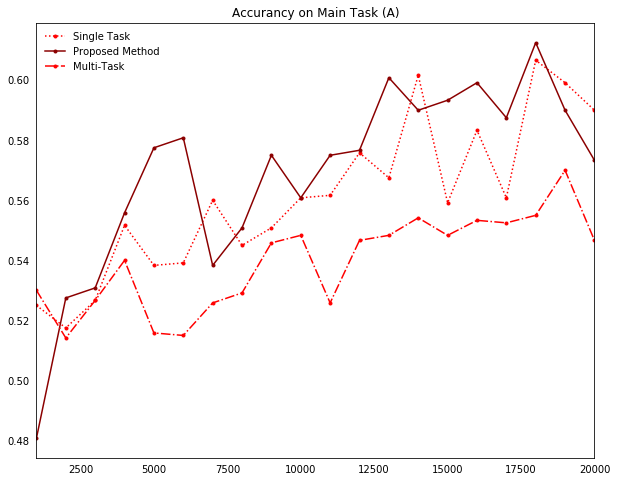

In [37]:
df = pd.read_csv('../bckp/imagenet_3.csv', index_col = 0)
df.index = [(x+1)*steps for x in df.index]
styles = ['red','darkred','red']
linestyle = [':','-','-.']
fig, ax = plt.subplots(figsize=(10,8))
for col, style, ls in zip(df.columns, styles, linestyle):
    df[col].plot(style=style, ax=ax, linestyle=ls, marker = '.')
ax.legend(frameon=False)
plt.title('Accurancy on Main Task (A)')
ax.xaxis.set_ticks_position('none') # remove xticks - as in paper
ax.yaxis.set_ticks_position('none') # remove yticks - as in paper